In [ ]:
import torch.nn as nn
import torch 
from torch.nn import functional as F
from torchvision import models
import h5py
import random
import os
from PIL import Image
import numpy as np
import cv2
import shutil

from tqdm import tqdm
import time
import random
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset
from torch.autograd import Variable

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def save_checkpoint(state, is_best, model_name, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, model_name + '.pth.tar')  

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def load_data(img_path, image_size, downsample = 1, train = True):
    
    density_path = img_path.replace('.jpg','.h5').replace('images', 'ground-truth-h5-new')
    img = Image.open(img_path).convert('RGB')
    density_file = h5py.File(density_path, 'r')
    density = np.asarray(density_file['density'])


    # old_x = image_size[0]
    # old_y = image_size[1]
  
    # img = img.resize ((old_x, old_y), Image.ANTIALIAS)
    # density = cv2.resize(density, (old_x, old_y), cv2.INTER_CUBIC)
    

    if train:
        ratio = 0.5
        crop_size = (int(img.size[0]*ratio),int(img.size[1]*ratio))
        rdn_value = random.random()
        if rdn_value<0.25:
            dx = 0
            dy = 0
        elif rdn_value<0.5:
            dx = int(img.size[0]*ratio)
            dy = 0
        elif rdn_value<0.75:
            dx = 0
            dy = int(img.size[1]*ratio)
        else:
            dx = int(img.size[0]*ratio)
            dy = int(img.size[1]*ratio)

        

        img = img.crop((dx,dy,crop_size[0]+dx,crop_size[1]+dy))
      
        density = density[dy:(crop_size[1]+dy),dx:(crop_size[0]+dx)]

        if random.random()>0.8:
            density = np.fliplr(density)
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
    
    

    #img = img.resize ((int(img.size[0] / downsample * 2), int(img.size[1] / downsample * 2)), Image.ANTIALIAS)
    density = cv2.resize(density,(int(density.shape[1] / downsample), int(density.shape[0] / downsample)), interpolation = cv2.INTER_CUBIC) * 64
    
    # f, axarr = plt.subplots(2, figsize=(10,10))
    # axarr[0].imshow(img)
    # axarr[1].imshow(density)

    return img, density


class CrowdDatasetShanghaiB(Dataset):
    def __init__(self, img_root_folder, densities_root_folder, image_size, shuffle=True, transform=None, batch_size = 28, train = False, downsample = 4, num_workers=4, seen = 0):
        

        self.img_root_folder = img_root_folder
        self.densities_root_folder = densities_root_folder
        self.shuffle = shuffle
        self.transform = transform
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train = train
        self.downsample = downsample
        self.image_size = image_size
        self.seen = seen
        
        self.img_names = [filename for filename in os.listdir(img_root_folder) if os.path.isfile(os.path.join(img_root_folder,filename))]
        self.n_samples = len(self.img_names)
        random.shuffle(self.img_names)
        
        
    def __len__(self):
        return self.n_samples
    def __getitem__(self, index):
        assert index <= len(self), 'index range error'
        
        img_path = os.path.join(self.img_root_folder, self.img_names[index])
        
        img,target = load_data(img_path, self.image_size, self.downsample, self.train)
        
        if self.transform is not None:
            img = self.transform(img)
        return img, target

In [ ]:
import torch.nn as nn
import torch
from torch.nn import functional as F
from torchvision import models

class ContextualModule(nn.Module):
    def __init__(self, features, out_features=512, sizes=(1, 2, 3, 6)):
        super(ContextualModule, self).__init__()
        self.scales = []
        self.scales = nn.ModuleList([self._make_scale(features, size) for size in sizes])
        self.bottleneck = nn.Conv2d(features * 2, out_features, kernel_size=1)
        self.relu = nn.ReLU()
        self.weight_net = nn.Conv2d(features,features,kernel_size=1)

    def __make_weight(self,feature,scale_feature):
        weight_feature = feature - scale_feature
        return F.sigmoid(self.weight_net(weight_feature))

    def _make_scale(self, features, size):
        prior = nn.AdaptiveAvgPool2d(output_size=(size, size))
        conv = nn.Conv2d(features, features, kernel_size=1, bias=False)
        return nn.Sequential(prior, conv)

    def forward(self, feats):
        h, w = feats.size(2), feats.size(3)
        multi_scales = [F.upsample(input=stage(feats), size=(h, w), mode='bilinear') for stage in self.scales]
        weights = [self.__make_weight(feats,scale_feature) for scale_feature in multi_scales]
        overall_features = [(multi_scales[0]*weights[0]+multi_scales[1]*weights[1]+multi_scales[2]*weights[2]+multi_scales[3]*weights[3])/(weights[0]+weights[1]+weights[2]+weights[3])]+ [feats]
        bottle = self.bottleneck(torch.cat(overall_features, 1))
        return self.relu(bottle)

class CANNet(nn.Module):
    def __init__(self, name, load_weights=False):
        super(CANNet, self).__init__()
        self.seen = 0
        self.name = name
        self.context = ContextualModule(512, 512)
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat  = [512, 512, 512,256,128,64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat,in_channels = 512,batch_norm=True, dilation = True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        if not load_weights:
            mod = models.vgg16(pretrained = True)
            self._initialize_weights()
            for i in range(len(self.frontend)):
                if isinstance(self.frontend[i], nn.Conv2d):
                    self.frontend[i].weight.data.copy_(mod.features[i].weight.data)
                    self.frontend[i].bias.data.copy_(mod.features[i].bias.data)
                    self.frontend[i].weight.requires_grad = False

    def forward(self,x):
        x = self.frontend(x)
        x = self.context(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [ ]:
train_image_root='/content/drive/MyDrive/part_B/train_data/images'
train_density_root='/content/drive/MyDrive/part_B/train_data/ground-truth-h5-new'
test_image_root='/content/drive/MyDrive/part_B/test_data/images'
test_density_root='/content/drive/MyDrive/part_B/test_data/ground-truth-h5-new'
device_used ='cuda' 

In [ ]:
#model params
lr           = 1e-4
batch_size   = 15
weight_decay = 5*1e-4
n_epochs     = 3
seed         = time.time()
downsample = 8
image_size = [1152, 768]
shuffle = True
transform = transforms.Compose([
                  transforms.ToTensor(),
                  transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
             ])
n_workers = 2
print_freq = 1

In [ ]:
device = torch.device(device_used)
torch.cuda.manual_seed(seed)
model = CANNet(name = "CAN").to(device)
criterion=nn.MSELoss(size_average=False).to(device)
optimizer=torch.optim.Adam(model.parameters(), lr, weight_decay= weight_decay)

if not os.path.exists('./checkpoints'):
    os.mkdir('./checkpoints')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
train_dataset = CrowdDatasetShanghaiB(train_image_root, train_density_root, image_size, shuffle, transform, batch_size, True, downsample, n_workers)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, num_workers = n_workers)
test_dataset = CrowdDatasetShanghaiB(test_image_root, test_density_root, image_size, shuffle, transform, batch_size, False, downsample, n_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 1 )

In [ ]:
def train(model, criterion, optimizer, epoch):

    losses = AverageMeter()
    batch_time = AverageMeter()
    data_time = AverageMeter()

    print('epoch %d, processed %d samples, lr %.10f' % (epoch, epoch * len(train_loader.dataset), lr))

    model.train()
    end = time.time()

    for i,(img, density)in enumerate(train_loader):
        data_time.update(time.time() - end)

        img = img.cuda()
        img = Variable(img)
      
        output = model(img)[:,0,:,:]

        density = density.type(torch.FloatTensor).cuda()
        density = Variable(density)

        loss = criterion(output, density)

        losses.update(loss.item(), img.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_time.update(time.time() - end)
        end = time.time()

        
        print('Epoch: [{0}][{1}/{2}]\t'
                'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                .format(
                epoch, i, len(train_loader), batch_time=batch_time,
                data_time=data_time, loss=losses))
            

def validate(model, criterion):
    print ('begin val')
    model.eval()
    mae = 0
    for i,(img, target) in enumerate(test_loader):
        h,w = img.shape[2:4]
        h_d = int(h/2)
        w_d = int(w/2)
        img_1 = Variable(img[:,:,:int(h_d),:w_d].cuda())
        img_2 = Variable(img[:,:,:h_d,w_d:].cuda())
        img_3 = Variable(img[:,:,h_d:,:w_d].cuda())
        img_4 = Variable(img[:,:,h_d:,w_d:].cuda())
        density_1 = model(img_1).data.cpu().numpy()
        density_2 = model(img_2).data.cpu().numpy()
        density_3 = model(img_3).data.cpu().numpy()
        density_4 = model(img_4).data.cpu().numpy()

        pred_sum = density_1.sum()+density_2.sum()+density_3.sum()+density_4.sum()

        mae += abs(pred_sum-target.sum())

    mae = mae/len(test_loader)
    print(' * MAE {mae:.3f} '
              .format(mae=mae))

    return mae

In [ ]:
#best_prec1 = 1000
n_epochs = 5
for epoch in range(n_epochs):
        train(model, criterion, optimizer, epoch)
        prec1 = validate(model, criterion)

        is_best = prec1 < best_prec1
        best_prec1 = min(prec1, best_prec1)
        print(' * best MAE {mae:.3f} '
              .format(mae=best_prec1))
        save_checkpoint({
            'state_dict': model.state_dict(),
        }, is_best, model.name)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([1, 1, 96, 128])
(96, 128)


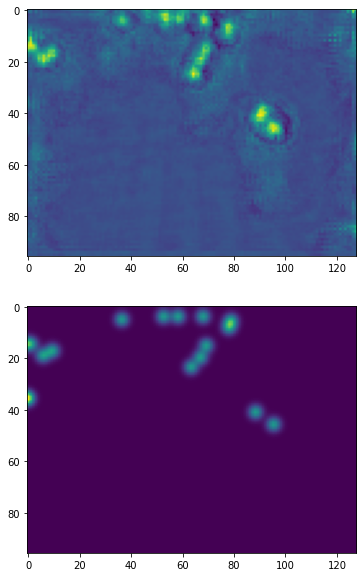

In [ ]:
index=random.randint(0,len(test_loader)-1)
img,  gt_dmap=test_dataset[index]


img=img.unsqueeze(0).to(device)

et_dmap = model(img)
# et_dmap = et_dmap.squeeze(0).detach().cpu().numpy()


#plt.imshow(img[0].detach().cpu().numpy().reshape(384, 576, 3))
print(et_dmap.shape)
print(gt_dmap.shape)

et_dmap = et_dmap[0][0].detach().cpu().numpy()

f, axarr = plt.subplots(2, figsize=(10,10))
axarr[0].imshow(et_dmap)
axarr[1].imshow(gt_dmap)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


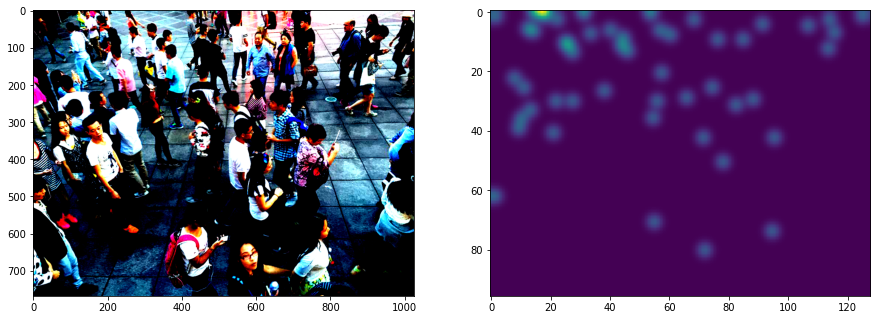

tensor(-36.3738, device='cuda:0', grad_fn=<SumBackward0>)
50.999749525609296


In [ ]:
#model = CANNet(pvt).to(device)
index=random.randint(0,len(test_loader)-1)
img,  gt_dmap=test_dataset[index]
img=img.unsqueeze(0).to(device)
et_dmap = model(img)


#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,2, figsize=(15,15)) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[ 0].imshow(img[0].detach().cpu().permute(1, 2, 0).numpy())
axarr[ 1].imshow(gt_dmap)
#axarr[ 2].imshow(et_dmap[0].squeeze(0).detach().cpu().numpy())
plt.show()
#plt.imshow(img[0].detach().cpu().permute(1, 2, 0).numpy())
#plt.imshow(et_dmap[0].squeeze(0).detach().cpu().numpy())
print(et_dmap.sum())
print(gt_dmap.sum())


In [ ]:


def load_data(img_path, image_size, downsample = 1, train = True):
    
    density_path = img_path.replace('.jpg','.h5').replace('images', 'ground-truth-h5-new')
    img = Image.open(img_path).convert('RGB')
    density = np.load(os.path.join(self.densities_root_folder, img_name.replace('.jpg','.npy')))


    # old_x = image_size[0]
    # old_y = image_size[1]
  
    # img = img.resize ((old_x, old_y), Image.ANTIALIAS)
    # density = cv2.resize(density, (old_x, old_y), cv2.INTER_CUBIC)
    

    if train:
        ratio = 0.5
        crop_size = (int(img.size[0]*ratio),int(img.size[1]*ratio))
        rdn_value = random.random()
        if rdn_value<0.25:
            dx = 0
            dy = 0
        elif rdn_value<0.5:
            dx = int(img.size[0]*ratio)
            dy = 0
        elif rdn_value<0.75:
            dx = 0
            dy = int(img.size[1]*ratio)
        else:
            dx = int(img.size[0]*ratio)
            dy = int(img.size[1]*ratio)

        

        img = img.crop((dx,dy,crop_size[0]+dx,crop_size[1]+dy))
      
        density = density[dy:(crop_size[1]+dy),dx:(crop_size[0]+dx)]

        if random.random()>0.8:
            density = np.fliplr(density)
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
    
    

    #img = img.resize ((int(img.size[0] / downsample * 2), int(img.size[1] / downsample * 2)), Image.ANTIALIAS)
    density = cv2.resize(density,(int(density.shape[1] / downsample), int(density.shape[0] / downsample)), interpolation = cv2.INTER_CUBIC) * 64
    
    # f, axarr = plt.subplots(2, figsize=(10,10))
    # axarr[0].imshow(img)
    # axarr[1].imshow(density)

    return img, density

3.7.10
